# Otimização de Arquitetura de Redes Neurais com Algoritmos Genéticos 

## Teste 03: Dataset Fashion-Mnist

### 01. Importação de Bibliotecas

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Separação do Dataset

In [2]:
# Preparando os datasets e dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

### 03. Arquitetura inicial da Rede Neural

In [3]:
# Definindo a arquitetura da rede neural
class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, n_neurons)
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

### 04. Função de treinamento e avaliação do Modelo

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Algoritmo Genético

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [40:40<00:00, 488.03s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [95, 0, 0.07785158996560364, 46]
Parâmetros: {'n_neurons': 95, 'activation_idx': 0, 'learning_rate': 0.07785158996560364, 'batch_size': 46}


### 06. Treinamento dos Modelos

#### Modelo Não Otimizado 1

In [9]:
# Modelo Não Otimizado 1
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.01)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|██████▊                                                             | 1/10 [00:21<03:14, 21.59s/época]

Época 1, Loss: 1.6592



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:40<02:39, 20.00s/época]

Época 2, Loss: 1.0417



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:57<02:11, 18.78s/época]

Época 3, Loss: 0.8246



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:13<01:45, 17.64s/época]

Época 4, Loss: 0.7229



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:29<01:25, 17.00s/época]

Época 5, Loss: 0.6630



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:45<01:06, 16.55s/época]

Época 6, Loss: 0.6208



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [02:00<00:48, 16.17s/época]

Época 7, Loss: 0.5886



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:16<00:32, 16.04s/época]

Época 8, Loss: 0.5630



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:33<00:16, 16.29s/época]

Época 9, Loss: 0.5424



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:49<00:00, 16.98s/época]


Época 10, Loss: 0.5252


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.44batch/s]


#### Modelo Não Otimizado 2

In [10]:
# Modelo Não Otimizado 2
model_non_opt_2 = SimpleNet(n_neurons=200, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|██████▊                                                             | 1/10 [00:18<02:44, 18.27s/época]

Época 1, Loss: 0.5815



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:34<02:17, 17.20s/época]

Época 2, Loss: 0.4240



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:50<01:55, 16.51s/época]

Época 3, Loss: 0.3846



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:05<01:36, 16.09s/época]

Época 4, Loss: 0.3602



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:21<01:19, 15.92s/época]

Época 5, Loss: 0.3409



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:37<01:03, 15.87s/época]

Época 6, Loss: 0.3245



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:52<00:47, 15.81s/época]

Época 7, Loss: 0.3106



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:08<00:31, 15.78s/época]

Época 8, Loss: 0.2998



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:24<00:15, 15.93s/época]

Época 9, Loss: 0.2887



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.26s/época]


Época 10, Loss: 0.2786


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 39.45batch/s]


#### Modelo Não Otimizado 3

In [12]:
# Modelo Não Otimizado 3
model_non_opt_3 = SimpleNet(n_neurons=150, activation_fn=nn.Sigmoid())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.07)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_3, optimizer_3)

Treinamento:  10%|██████▊                                                             | 1/10 [00:18<02:44, 18.26s/época]

Época 1, Loss: 0.8190



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:34<02:15, 16.91s/época]

Época 2, Loss: 0.5137



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:50<01:55, 16.53s/época]

Época 3, Loss: 0.4609



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:06<01:38, 16.35s/época]

Época 4, Loss: 0.4321



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:22<01:21, 16.37s/época]

Época 5, Loss: 0.4135



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:38<01:05, 16.31s/época]

Época 6, Loss: 0.3979



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:55<00:48, 16.29s/época]

Época 7, Loss: 0.3869



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:12<00:33, 16.74s/época]

Época 8, Loss: 0.3752



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:30<00:16, 16.86s/época]

Época 9, Loss: 0.3664



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/época]


Época 10, Loss: 0.3587


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.04batch/s]


#### Modelo Otimizado

In [13]:
# Modelo Otimizado
activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|██████▊                                                             | 1/10 [00:17<02:39, 17.69s/época]

Época 1, Loss: 0.5660



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:33<02:13, 16.67s/época]

Época 2, Loss: 0.4144



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:49<01:53, 16.27s/época]

Época 3, Loss: 0.3750



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:05<01:37, 16.21s/época]

Época 4, Loss: 0.3489



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:21<01:20, 16.05s/época]

Época 5, Loss: 0.3309



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:37<01:04, 16.00s/época]

Época 6, Loss: 0.3169



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:53<00:47, 15.95s/época]

Época 7, Loss: 0.3024



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:10<00:32, 16.36s/época]

Época 8, Loss: 0.2927



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:29<00:17, 17.17s/época]

Época 9, Loss: 0.2818



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.73s/época]


Época 10, Loss: 0.2739


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.52batch/s]


### 07. Avaliação dos Modelos

In [14]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.8056, Loss = 0.5252, Tempo = 172.31s
Modelo Não Otimizado 2: Acurácia = 0.8626, Loss = 0.2786, Tempo = 165.15s
Modelo Não Otimizado 3: Acurácia = 0.8500, Loss = 0.3587, Tempo = 169.91s
Modelo Otimizado: Acurácia = 0.8769, Loss = 0.2739, Tempo = 169.92s


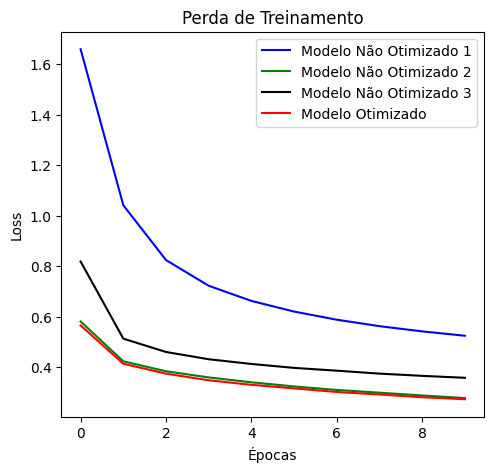

In [15]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Modelo Não Otimizado 1', color='blue')
plt.plot(train_losses_non_opt_2, label='Modelo Não Otimizado 2', color='green')
plt.plot(train_losses_non_opt_3, label='Modelo Não Otimizado 3', color='black')
plt.plot(train_losses_opt, label='Modelo Otimizado', color='red')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Perda de Treinamento')
plt.legend()

In [ ]:
# Gráfico de comparação de acurácia e tempo de treinamento
plt.subplot(1, 2, 2)
bar_width = 0.35
index = range(2)
bar1 = plt.bar(index, [accuracy_non_opt, accuracy_opt], bar_width, label='Acurácia')
bar2 = plt.bar([i + bar_width for i in index], [time_non_opt, time_opt], bar_width, label='Tempo (s)')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.title('Comparação de Modelos')
plt.xticks([i + bar_width / 2 for i in index], ['Não Otimizado', 'Otimizado'])
plt.legend()

plt.tight_layout()
plt.show()

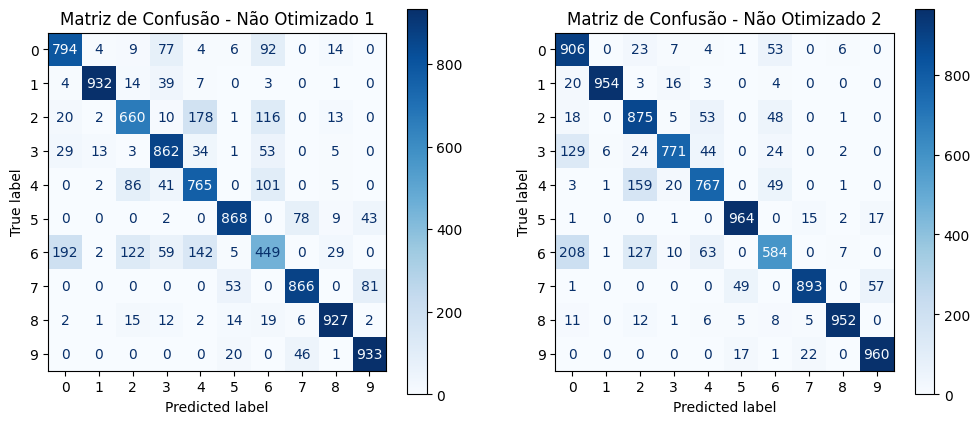

In [17]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Não Otimizado 2')

plt.show()

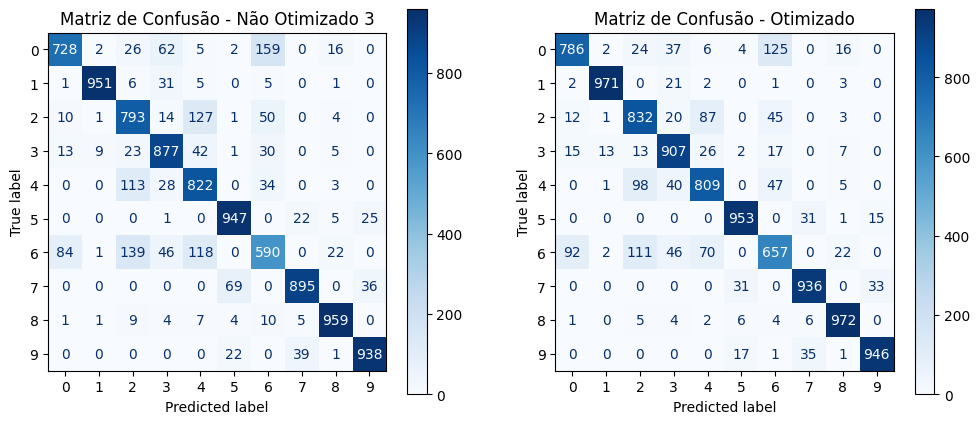

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Otimizado')

plt.show()